**Для начала предобработаем данные, даты переведём из object в datetime**

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
%matplotlib inline
%pylab inline
ads_clients_data = pd.read_csv('C:/Users/nastk/Downloads/ads_clients_data.csv')
ads_data = pd.read_csv('~/Downloads/ads_data.csv')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [33]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [34]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [35]:
ads_clients_data.dtypes

date               object
client_union_id     int64
community_id        int64
create_date        object
dtype: object

In [36]:
ads_data.dtypes

date                      object
time                      object
event                     object
platform                  object
ad_id                      int64
client_union_id            int64
campaign_union_id          int64
ad_cost_type              object
ad_cost                  float64
has_video                  int64
target_audience_count      int64
dtype: object

In [37]:
ads_data['time'] = pd.to_datetime(ads_data['time'])

In [38]:
ads_data['date'] = pd.to_datetime(ads_data['date'])

In [39]:
ads_data.dtypes

date                     datetime64[ns]
time                     datetime64[ns]
event                            object
platform                         object
ad_id                             int64
client_union_id                   int64
campaign_union_id                 int64
ad_cost_type                     object
ad_cost                         float64
has_video                         int64
target_audience_count             int64
dtype: object

**Далее посчитаем количество разных рекламных событий (показы и клики) по объявлениям**

In [40]:
ads_event_and_adid = ads_data \
    .groupby(['event', 'ad_id'], as_index = False) \
    .agg({'time':'count'}) \
    .pivot(index = 'ad_id', columns = 'event', values = 'time') \
    .reset_index()

In [41]:
ads_event_and_adid

event,ad_id,click,view
0,2,1.0,101.0
1,3,3.0,184.0
2,1902,1.0,41.0
3,2064,NaN,35.0
4,2132,1.0,58.0
...,...,...,...
960,122004,4.0,100.0
961,122013,NaN,156.0
962,122023,NaN,68.0
963,122031,1.0,138.0


**Посмотрим на распределение показов объявлений**

In [42]:
sns.set(font_scale=2, style="whitegrid", rc={'figure.figsize':(20,7)})
ads_event_and_adid_logview = np.log(ads_event_and_adid.view)
ads_event_and_adid['ads_event_and_adid_logview'] = ads_event_and_adid_logview

C:\Users\nastk\AppData\Local\Temp\ipykernel_396\3232012680.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\nastk\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='ads_event_and_adid_logview', ylabel='Density'>

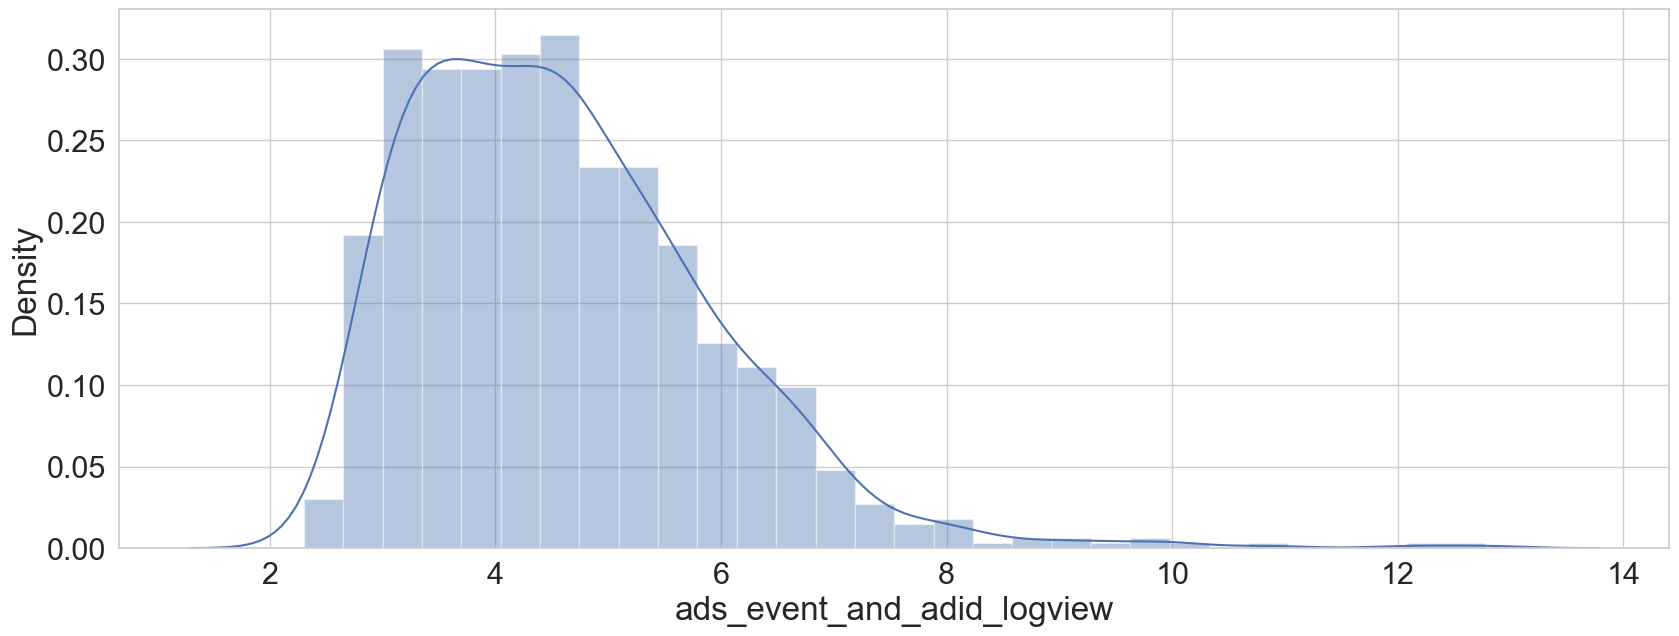

In [43]:
sns.distplot(ads_event_and_adid.ads_event_and_adid_logview)

**Теперь нужно найти среднее количество показов на 1 объявление (ad_id) по дням.** 

In [44]:
mean_view_on_ad = ads_data \
    .query('event == "view"') \
    .groupby(['date','ad_id'], as_index = False) \
    .agg({'time' : 'count'}) \
    .groupby('date', as_index = False) \
    .agg({'time' :'mean'})

In [45]:
mean_view_on_ad

,date,time
0,2019-04-01,154.482270
1,2019-04-02,137.786982
2,2019-04-03,163.952778
3,2019-04-04,675.901720
4,2019-04-05,919.109677
5,2019-04-06,277.122727


**Объединим данные рекламы с данными о рекламных клиентах и найдем среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).**

In [46]:
ads_data_with_clients = ads_data.merge(ads_clients_data, on = 'client_union_id', how = 'outer')

In [47]:
ads_data_with_clients.dtypes # замечаем, что create_date имеет тип object, исправим это

date_x                   datetime64[ns]
time                     datetime64[ns]
event                            object
platform                         object
ad_id                           float64
client_union_id                   int64
campaign_union_id               float64
ad_cost_type                     object
ad_cost                         float64
has_video                       float64
target_audience_count           float64
date_y                           object
community_id                      int64
create_date                      object
dtype: object

In [48]:
ads_data_with_clients['create_date'] = pd.to_datetime(ads_data_with_clients['create_date'])
ads_data_with_clients['date_y'] = pd.to_datetime(ads_data_with_clients['date_y'])

In [49]:
ads_data_with_clients.dtypes

date_x                   datetime64[ns]
time                     datetime64[ns]
event                            object
platform                         object
ad_id                           float64
client_union_id                   int64
campaign_union_id               float64
ad_cost_type                     object
ad_cost                         float64
has_video                       float64
target_audience_count           float64
date_y                   datetime64[ns]
community_id                      int64
create_date              datetime64[ns]
dtype: object

In [50]:
ads_data_with_clients.head()

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_y,community_id,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061.0,34734,45061.0,CPM,200.6,0.0,1955269.0,2020-05-07,-130129582,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061.0,34734,45061.0,CPM,200.6,0.0,1955269.0,2020-05-07,-130129582,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061.0,34734,45061.0,CPM,200.6,0.0,1955269.0,2020-05-07,-130129582,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061.0,34734,45061.0,CPM,200.6,0.0,1955269.0,2020-05-07,-130129582,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061.0,34734,45061.0,CPM,200.6,0.0,1955269.0,2020-05-07,-130129582,2018-12-04


In [51]:
ads_data_with_clients['difference_dates'] = ads_data_with_clients.date_x - ads_data_with_clients.create_date

In [52]:
ads_data_with_clients.head()

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_y,community_id,create_date,difference_dates
0,2019-04-01,2019-04-01 00:00:48,view,android,45061.0,34734,45061.0,CPM,200.6,0.0,1955269.0,2020-05-07,-130129582,2018-12-04,118 days
1,2019-04-01,2019-04-01 00:03:28,view,android,45061.0,34734,45061.0,CPM,200.6,0.0,1955269.0,2020-05-07,-130129582,2018-12-04,118 days
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061.0,34734,45061.0,CPM,200.6,0.0,1955269.0,2020-05-07,-130129582,2018-12-04,118 days
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061.0,34734,45061.0,CPM,200.6,0.0,1955269.0,2020-05-07,-130129582,2018-12-04,118 days
4,2019-04-01,2019-04-01 00:15:42,view,android,45061.0,34734,45061.0,CPM,200.6,0.0,1955269.0,2020-05-07,-130129582,2018-12-04,118 days


In [53]:
ads_adid_diff = ads_data_with_clients \
    .dropna(subset=['date_x']) \
    .groupby('client_union_id', as_index = False) \
    .agg({'difference_dates': 'min'})

In [54]:
ads_adid_diff

,client_union_id,difference_dates
0,1,98 days
1,9,114 days
2,13,66 days
3,16,105 days
4,20,32 days
...,...,...
833,122004,67 days
834,122013,151 days
835,122023,126 days
836,122031,96 days


In [55]:
mean_difference_dates = ads_adid_diff['difference_dates'].mean()
mean_difference_dates

Timedelta('124 days 09:04:43.532219570')

**Вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.**

In [56]:
clients_with_ads_365 = ads_adid_diff[ads_adid_diff['difference_dates'] <= pd.Timedelta(365, unit="days")]['client_union_id'].nunique()
clients_with_ads_365

838

In [57]:
clients_all = ads_clients_data['client_union_id'].nunique()
clients_all

122078

In [58]:
conversion = round(100 * clients_with_ads_365 / clients_all, 2)
conversion

0.69

**Разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления.
Определме, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней)** 

In [59]:
cut_clients_date = pd.cut(ads_adid_diff.difference_dates, 
    bins=pd.to_timedelta(['0d', '30d', '90d', '180d', '365d']),
    labels=['0-30 days', '30-90 days', '90-180 days', '180-365 days']) \
    .value_counts() \
    .to_frame(name = 'count_clients') \
    .reset_index()
cut_clients_date

,difference_dates,count_clients
0,90-180 days,396
1,30-90 days,263
2,180-365 days,168
3,0-30 days,11


**Построим интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них. Расположм их так, чтобы внизу была самая малочисленная, а наверху – самая большая.**

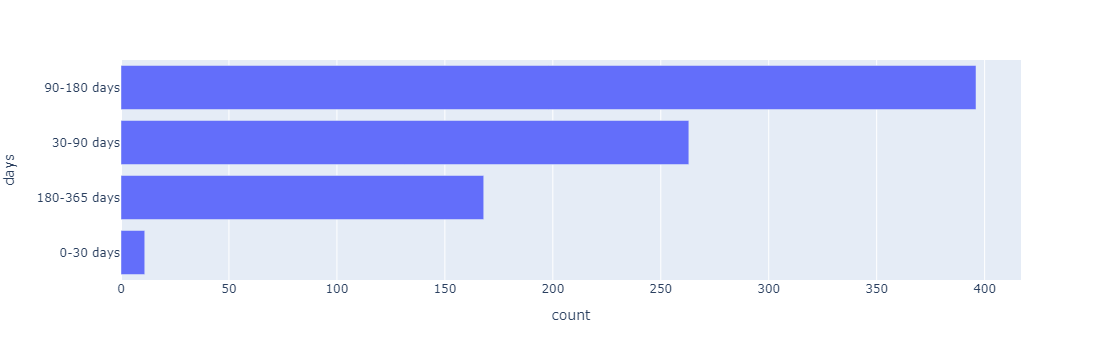

In [60]:
int_bar = px.bar(x = cut_clients_date.count_clients, y = cut_clients_date.difference_dates)
int_bar.update_layout(yaxis = {"categoryorder":"total ascending"})
int_bar.update_layout(xaxis_title='count', yaxis_title='days')

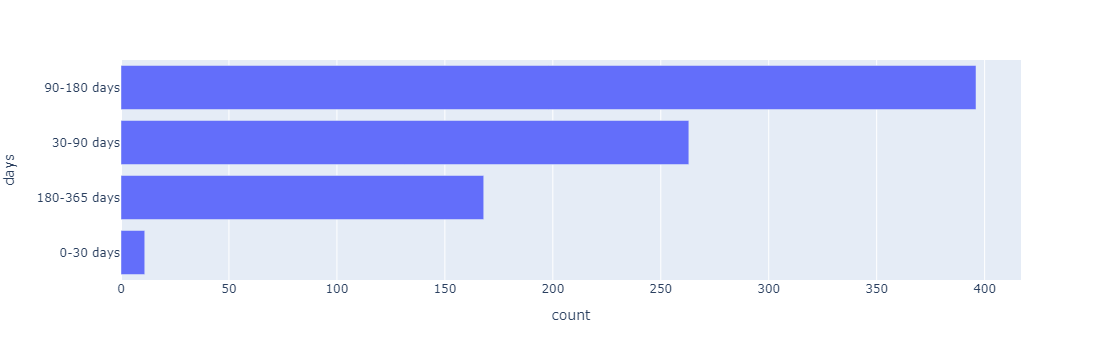

In [61]:
int_bar.show()